In [1]:
#Import Libraries
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

In [2]:
#Load the Dataset
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

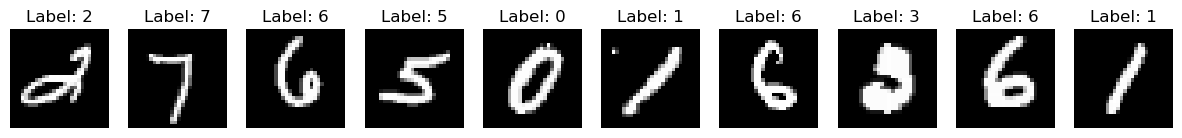

In [3]:
#Initial Visualization of Images
# Step 1: Extract pixel data and labels from the training DataFrame
X = train_df.drop("label", axis=1).values  # Extract pixel values
y = train_df["label"].values               # Extract labels

# Step 2: Normalize pixel values to the range [0, 1]
X = X / 255.0

# Step 3: Plot several sample images with their corresponding labels
import matplotlib.pyplot as plt

def plot_samples(X, y, n=10):
    """
    Display n random samples from the dataset.
    Each image is reshaped into 28x28 pixels.
    """
    plt.figure(figsize=(15, 2))
    indices = np.random.choice(len(X), n, replace=False)
    for i, idx in enumerate(indices):
        image = X[idx].reshape(28, 28)
        label = y[idx]
        plt.subplot(1, n, i+1)
        plt.imshow(image, cmap="gray")
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.show()

# Call the function to visualize 10 random images
plot_samples(X, y)


In [4]:
#Data Preprocessing and Loader Creation

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

# Step 1: Separate features and labels
X = train_df.drop("label", axis=1).values.astype(np.float32)  # Shape: (n_samples, 784)
y = train_df["label"].values.astype(np.int64)                # Labels: integers 0-9

# Step 2: Normalize pixel values to [0, 1]
X = X / 255.0

# Step 3: Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Step 4: Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)

X_val_tensor = torch.tensor(X_val)
y_val_tensor = torch.tensor(y_val)

# Step 5: Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Step 6: Create DataLoaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [ ]:
# Evaluation and Visualization